In [1]:
from IPython.display import Image

Translated by [Naoto Usuyama](https://github.com/usuyama) December 22, 2017

# CNTK 101: Logistic Regression と機械学習への導入

このチュートリアルでは、機械学習とCNTKに新しくふれる方を対象に、シンプルながら強力なモデルを学習していきます。CNTKは、様々な計算資源 (CPU、GPU、CPU/GPUのクラスタ) に対応しているため、このチュートリアルで学習したモデルは大規模なデータにも適応することができます。

このJupyterノートブックはPython APIを使用しています。Brainscriptを使った例は[こちら](https://github.com/Microsoft/CNTK/tree/v2.0.beta2.0/Examples/Tutorials/LogisticRegressionAndMultiClass)をご覧ください。

## 導入

**問題設定 (分類問題)**:
ある患者の腫瘍が、良性か悪性かを判別して欲しいと、ある病院から依頼を受けました。与えられるデータは、患者の年齢と腫瘍の大きさです。実際の現場では、より多くの特徴量を扱い、データが取得された病院や研究所も考慮しなければいけませんが、今回は簡単のためシミュレーションデータを使います。直感的には、若い患者で腫瘍のサイズが小さいほど、良性の可能性が高いような気がします。今回使うシミュレーションデータをプロットすると、下のような図になります(青が良性、赤が悪性) 。

In [2]:
# Figure 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

**ゴール**:
２つの特徴量(年齢、腫瘍の大きさ)から、患者の腫瘍が良性か悪性かを推定します。今回は、ディープラーニングの基礎となる線形分類器を作ります。

In [3]:
# Figure 2
Image(url= "https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400)

上の図では、緑の線が学習された線形モデルを表しています。この例では、いくつか青い点を間違って分類してしまっていますが、後ほど改善する手法についても学びます。

**アプローチ**: 
一般的に、5つのステップでモデルの学習は行われます。

>1. データの読み込み (Data reading): 今回は、シミュレーションでデータを生成しますが、一般にはファイルやデータベースからデータを読み込みます。
>2. データの前処理 (Data preprocessing): 一般的には、偏りを避けるため、各特徴量を0から1にスケールし直す標準化を行いますが、今回は簡単のため省略します。詳しくは、[feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) を参照ください。
>3. モデルの作成 (Model creation): このチュートリアルでは、基本の線形モデルを使います。 
>4. モデルの学習 (Learning the model): 線形モデル ([linear regression](https://en.wikipedia.org/wiki/Linear_regression)) の学習は色々な手法がありますが、今回は確率的勾配降下法 (Stochastic Gradient Descent a.k.a. [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)) を用います。モデルの学習は、トレーニングとも呼びます。
>5. 評価 (Evaluation): 学習したモデルが、実際にうまく働くかどうかを評価します。モデルの学習に用いなかった、答え (ground-truth) がわかっているデータを用いて、モデルの分類結果と答えが合うかどうかを確認します。

## Logistic Regression
[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) は機械学習の基礎的な手法で、特徴量に線形の重みを付け、分類結果の確率を出力します。今回の例では、0から1の値として確率が出力されるので、ある閾値 (例えば0.5) を決めると2クラスの分類ができます。2クラス以上への拡張も簡単にできます。


In [4]:
# Figure 3
Image(url= "https://www.cntk.ai/jup/logistic_neuron.jpg", width=300, height=200)

上の図は、モデルが入力されたそれぞれの特徴量に重みを付け、集約し、確率を出力する様子を表しています。2クラスの場合は、シグモイド関数 ([sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) function) で0から1の値に集約され、多クラスの場合は、ソフトマックス関数  ([softmax](https://en.wikipedia.org/wiki/Softmax_function) function) で0から1の値の要素を持ったベクトルに集約されます。

In [5]:
# Import the relevant components
from __future__ import print_function
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix the random seed so that LR examples are repeatable

## シミュレーションデータの生成
`numpy` ライブラリを使って、腫瘍データを模したデータを生成します。それぞれのデータポイントは、2つの特徴量 (年齢と腫瘍の大きさ)を持ち、良性か悪性のどちらかのクラスに属します。

今回は、2つのクラス(ラベル)は0か1で表せるので、バイナリ(二値)分類問題と言えます。

In [6]:
# Define the network
input_dim = 2
num_output_classes = 2

### 入力とラベル

今回はシミュレーションデータを使いますが、実際の問題では[reader][]を使ってデータを読み込みます。[reader][]の使い方については、後ほど扱います。シミュレーションで生成した年齢の値は、もう一つの変数(腫瘍の大きさ)と同じ範囲の値になるようにスケールダウンします。このスケールを調整する作業は、重要な前処理なので、チュートリアルの後半でより詳しく扱う予定です。実際の問題で、より多くの特徴量が利用可能な場合は、CNTKでは[tensor][]として多次元データを表します。[tensor][]についても後ほど扱う予定です。

[reader]: https://github.com/Microsoft/CNTK/search?p=1&q=reader&type=Wikis&utf8=%E2%9C%93
[tensor]: https://en.wikipedia.org/wiki/Tensor

In [7]:
# Ensure that we always get the same results
np.random.seed(0)

# Helper function to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable 
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    
    # Specify the data type to match the input variable used later in the tutorial 
    # (default type is double)
    X = X.astype(np.float32)    
    
    # convert class 0 into the vector "1 0 0", 
    # class 1 into the vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y

In [8]:
# Create the input variables denoting the features and the label data. Note: the input 
# does not need additional info on the number of observations (Samples) since CNTK creates only 
# the network topology first 
mysamplesize = 32
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)

入力データを可視化してみましょう。

**Note**: もしimport `matplotlib.pyplot` が失敗した場合、`conda install matplotlib` か `pip install` を使って、`pyplot` バージョン依存を解決してください。

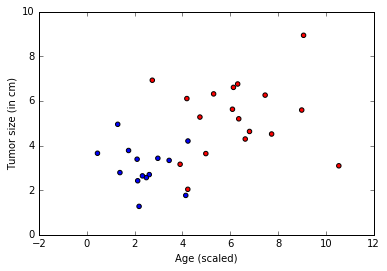

In [9]:
# Plot the data 
import matplotlib.pyplot as plt
%matplotlib inline

# let 0 represent malignant/red and 1 represent benign/blue 
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

# モデルの作成

Logistic regression network は様々な機械学習手法で使われている基本構成要素です。様々な要素を入力 (特徴量ベクター $\bf{x}$、図では青いノード) として受け取り、*evidence* ($z$) (アクチベーションとも呼ぶ、図では緑のノード) を出力します。 それぞれの入力要素 (x) に重み w (図では、線の太さで重みの大きさを表している) を掛けた値の和がエビデンスです。

In [10]:
# Figure 4
Image(url= "https://www.cntk.ai/jup/logistic_neuron2.jpg", width=300, height=200)

$\bf{w}$ は長さ$n$の重みベクター、$b$ は [bias](https://www.quora.com/What-does-the-bias-term-represent-in-logistic-regression) 項です。 Note: **太字** はベクターを表します。

$$z = \sum_{i=1}^n w_i \times x_i + b = \textbf{w} \cdot \textbf{x} + b$$ 

計算したエビデンス ($z$) は `sigmoid`関数(2クラスの場合)か`softmax`関数(多クラスの場合)を使って、0-1の範囲にスケールします。

CNTKにおける、ネットワークの入力:
-- **input** 変数
> CNTKでは、input_variable 関数を使って、入力コンテナを作ります。今回は、特徴量は2つなので、次元数2の入力コンテナを作ります。

In [11]:
feature = C.input_variable(input_dim, np.float32)

## ネットワークのセットアップ

上の数式を表した`linear_layer`関数を定義します。 
0. CNTK `times` オペレータを使って、重み($\bf{w}$)と特徴量($\bf{x}$)を掛け、
1. 最後にbias項 $b$ を足します。

`linear_layer`関数は、[CNTKオペレーション][]を使うことで、利用可能なハードウェア(CPUやGPU)に合わせて自動的に最適化されて実行されます。

[CNTKオペレーション]: https://www.cntk.ai/pythondocs/cntk.ops.html

In [12]:
# Define a dictionary to store the model parameters
mydict = {}

def linear_layer(input_var, output_dim):
    
    input_dim = input_var.shape[0]
    weight_param = C.parameter(shape=(input_dim, output_dim))
    bias_param = C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param

    return C.times(input_var, weight_param) + bias_param

`z` はネットワークの出力を表すのに使われます。

In [13]:
output_dim = num_output_classes
z = linear_layer(feature, output_dim)

### モデルパラメータの学習

モデルの準備ができたので、モデルパラメータ($\bf w$ と $b$)の学習を行っていきます。そのために、まず`softmax`関数を使ってエビデンス($z$)を確率($\textbf p$)に変換します。

$$ \textbf{p} = \mathrm{softmax}(z)$$ 

`softmax`関数 ([softmax function][])は[アクティベーション関数][]の1つです。各要素を足すと1となるようなベクターを出力するので、多クラス分類問題の確率分布として考えられます。 

[softmax function]: https://www.cntk.ai/pythondocs/cntk.ops.html?highlight=softmax#cntk.ops.softmax

[アクティベーション関数]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## 学習

上で述べたように、`softmax`関数の出力は観測値がそれぞれのクラスに属する確率になります。推定された確率分布が正解の分布にどれくらい近いかを表す関数を*cost*関数または*loss*関数といいます。*cost*関数または*loss*関数の値が小さくなるように、つまり、出力された確率が正解のクラスになるべく近くなるようにモデルの学習を行っていきます。

*cost/loss* 関数として、[`Cross-entropy`][]はよく使われていて、確率分布同士の近さを非負の値で返します。

$$ H(p) = - \sum_{j=1}^C y_j \log (p_j) $$

$p$ は`softmax`関数による推定確率分布、$y$は正解ラベル(ground-truth)です。2クラス問題の場合、`label`変数は2次元(`num_output_classes`と$C$に等しい)です。$y$、$p$共に、該当するクラスの要素が1、それ以外($C-1$次元)の要素は0の、$C$次元ベクターでは表されます。後ほど時間を取ってCross-Entropyを[よく理解する][]ことをおすすめします。

[`cross-entropy`]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[よく理解する]: http://colah.github.io/posts/2015-09-Visual-Information/

In [14]:
label = C.input_variable(num_output_classes, np.float32)
loss = C.cross_entropy_with_softmax(z, label)

#### 評価

`loss`関数を基準に学習したモデルを、[`classificaiton_error`]関数を使って評価します。モデルの出力結果と正解(ground-truth)がいくつ一致したかを返します。

[`classificaiton_error`]: https://www.cntk.ai/pythondocs/cntk.ops.html#cntk.ops.classification_error

In [15]:
eval_error = C.classification_error(z, label)

### 学習の調整

`loss`関数を小さくするために様々な最適化手法([optimization][])がありますが、今回は[Stochastic Gradient Descent][] (`sgd`)を使います。通常`sgd`では、ランダムな値でパラメータを初期化し、最急降下法([gradient-decent][])で反復的にパラメータを最適化していきます。それぞれのイテレーション(反復)では、データの一部を取り出して(*minibatch*と呼ぶ)、パラメータの更新に使います。大規模なデータセットに対してもメモリにのる分だけ*minibatch*として取り出し、効率的に学習を進められます。`loss`関数の値かあまり変わらなくなるか、指定回数以上反復したら、学習を終了します。

最適化の際に、重要なパラメータとして`learning_rate`があります。今のところは、"一度のイテレーションでどの程度パラメータを変化させるか"を調節するパラメータと考えておけば良いですが、より詳しくはチュートリアルの後半で扱う予定です。

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Stochastic Gradient Descent]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[gradient-decent]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [16]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch) 
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

学習の様子を可視化するためのヘルパー関数を用意しておきます。

In [17]:
# Define a utility function to compute the moving average.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=10):
    if len(a) < w: 
        return a[:]    
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Define a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

### 学習

今回は、一回のイテレーションで使うサンプル数(`minibatch_size`)を25、学習する総サンプル数(`num_samples_to_train`)を20000と設定します。シミュレーションデータなので幾らでもサンプルを生成できますが、実際の問題では答え(ground-truth)がわかっているデータのうち、例えば70%で学習をし、残り30%で学習したモデルの評価をする事があります。

これで Logistic Regression モデル (feedfoward network) を学習する準備ができました。

In [18]:
# Initialize the parameters for the trainer
minibatch_size = 25
num_samples_to_train = 20000
num_minibatches_to_train = int(num_samples_to_train  / minibatch_size)

In [19]:
from collections import defaultdict

# Run the trainer and perform model training
training_progress_output_freq = 50
plotdata = defaultdict(list)

for i in range(0, num_minibatches_to_train):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Assign the minibatch data to the input variables and train the model on the minibatch
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.6931, Error: 0.32
Minibatch: 50, Loss: 1.9350, Error: 0.36
Minibatch: 100, Loss: 1.0764, Error: 0.32
Minibatch: 150, Loss: 0.4856, Error: 0.20
Minibatch: 200, Loss: 0.1319, Error: 0.08
Minibatch: 250, Loss: 0.1330, Error: 0.08
Minibatch: 300, Loss: 0.1012, Error: 0.04
Minibatch: 350, Loss: 0.1091, Error: 0.04
Minibatch: 400, Loss: 0.3094, Error: 0.08
Minibatch: 450, Loss: 0.3230, Error: 0.12
Minibatch: 500, Loss: 0.3986, Error: 0.20
Minibatch: 550, Loss: 0.6744, Error: 0.24
Minibatch: 600, Loss: 0.3004, Error: 0.12
Minibatch: 650, Loss: 0.1676, Error: 0.12
Minibatch: 700, Loss: 0.2777, Error: 0.12
Minibatch: 750, Loss: 0.2311, Error: 0.04


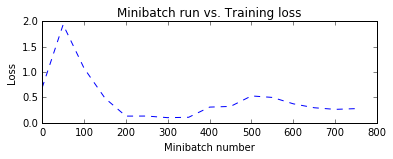

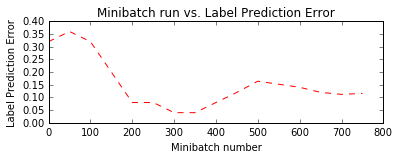

In [20]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## 評価 / テスト

これでネットワークの学習ができました。学習に使っていないデータを分類してみて、ネットワークの性能を評価してみましょう(**testing**と言う)。シミュレーションデータをさらに生成し、`trainer.test_minibatch`で予測を行います。この時、テストエラーがトレーニングエラーより格段に大きい場合は、学習したモデルは新しいデータに対してうまく動いていないという事になります。これはトレーニングデータを過剰に学習してしまった時に起こり、[overfitting][]と呼ばれます。CNTKでは[overfitting][]を避けるために様々なコンポーネントを用意していますので、後半のチュートリアルで紹介する予定です。

Note: 今回は説明のため、minibatchを1つだけ確認しますが、実際には、複数のminibatchでテストして平均を取った方が良いでしょう。

**質問** なぜそうするべきなのでしょうか？何度か違うminibatchでテストをして、プロットを確認してみてください。パターンが見えるでしょうか？

[overfitting]: https://en.wikipedia.org/wiki/Overfitting

In [21]:
# Run the trained model on a newly generated dataset
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({feature : features, label : labels})

0.12

### 予測の確認 / 評価

予測結果の評価のため、ネットワークの出力を`softmax`関数を使って0-1にスケールし、2クラスの確率分布に変換します。この確率分布は、それぞれの観測値が良性、悪性、それぞれのクラスに属する確率を表します。

In [22]:
out = C.softmax(z)
result = out.eval({feature : features})

それでは、予測結果と正解ラベル(ground-truth)を比較してみましょう。

**質問:** 
- いくつ不正解だったでしょうか？下のコードを変更して、どの観測値の分類に失敗したか表示するようにできますか？その場で下のコードを変更して、ツールバーから実行(run cell)できます。

In [23]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(x) for x in result])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


### 可視化
できる限り結果を可視化して確認するべきです。この例では、データが2次元なのでそのままプロットできます。多次元データの場合はより難しくなりますが、例えば [t-sne][] などの次元削減手法が使えます。

[t-sne]: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

[ 8.00007153 -8.00006485]


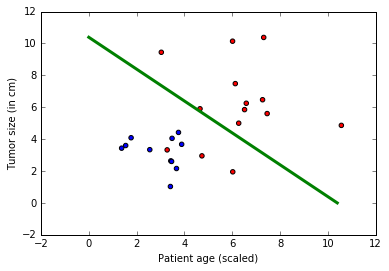

In [24]:
# Model parameters
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# Plot the data 
import matplotlib.pyplot as plt

# let 0 represent malignant/red, and 1 represent benign/blue
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Patient age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

**探索のヒント** 
- パラメータを変えてみるとどうなるでしょうか？例えば、`minibatch_size`を25から64にしてみてください。なぜエラーが増えるのでしょうか？
- 他のアクティベーション関数や最適化手法を試してみてください。
- 分類クラスが多クラスの場合はどうなるでしょうか？[multiclass logistic regression][]分類器を試してみてください。

[multiclass logistic regression]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression